## $\color{#dda}{\text{1: Libs (pmdarima)}}$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import pmdarima as pm
from pmdarima.utils import pacf, acf
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

## $\color{#dda}{\text{2: Creación de la serie de tiempo}}$

In [12]:
df = pd.read_csv('observaciones.csv')

df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], dayfirst = True)

fig = px.line(df, x='TIME_PERIOD', y='OBS_VALUE', title='Índice nacional de precios al consumidor quincenal')

fig.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=1153.141, Time=4.62 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1705.223, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1393.438, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1516.276, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1755.693, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=1498.146, Time=2.53 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=1389.436, Time=2.52 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=1146.251, Time=22.59 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=1261.916, Time=12.79 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=1152.077, Time=18.09 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=1144.420, Time=23.45 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=1414.551, Time=15.14 sec
 ARIMA(1,1,2)(1,0,2)[24] intercept   : AIC=1149.933, Time=27.77 sec
 ARIMA(2,1,1)(1,0,2)[24] intercept   : AIC=1144.593, Time=22.16 sec
 ARIMA(3,1,2

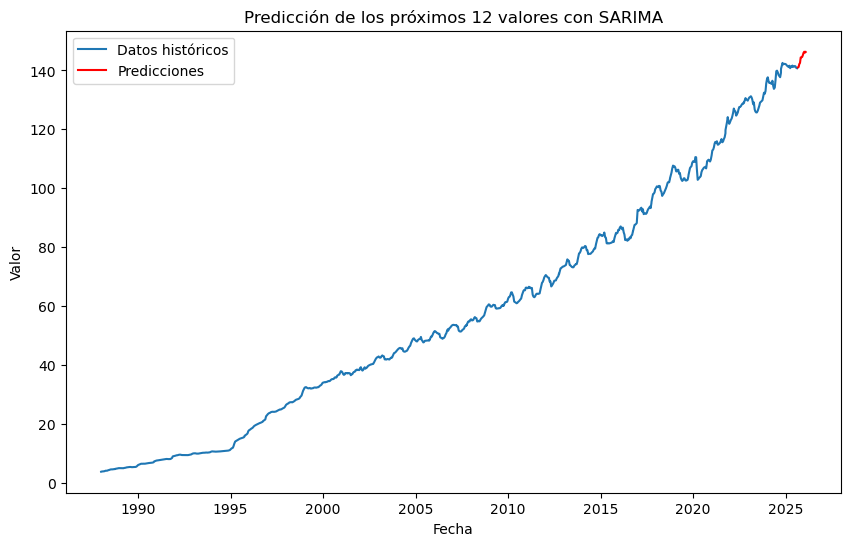

In [ ]:
# Asegúrate de que la columna 'OBS_VALUE' tiene los valores numéricos
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Establecer la columna de fecha como índice
df.set_index('TIME_PERIOD', inplace=True)

# Asegurar que los datos tengan una frecuencia de quincenal (2 semanas)
df = df.resample('2W').interpolate(method='linear')  # Resample a quincenal y llena con interpolación lineal

# Ahora crear el modelo SARIMA con pmdarima (Auto ARIMA)
model = pm.auto_arima(df['OBS_VALUE'], seasonal=True, m=24,  # m=26 para la periodicidad quincenal (2 semanas)
                      stepwise=True, trace=True)

# Ajustar el modelo
model.fit(df['OBS_VALUE'])

# Hacer la predicción para las próximas 12 quincenas
forecast = model.predict(n_periods=12)

# Mostrar las predicciones
print(forecast)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['OBS_VALUE'], label='Datos históricos')
plt.plot(pd.date_range(df.index[-1], periods=13, freq='2W')[1:], forecast, label='Predicciones', color='red')
plt.title('Predicción de los próximos 12 valores con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Best model:  ARIMA(1,1,3)(1,0,2)[24] intercept
Total fit time: 414.050 seconds

## $\color{#dda}{\text{3: Error}}$

In [10]:
actual = df['OBS_VALUE'][-12:].values  # Los últimos 12 valores reales
forecast = model.predict(n_periods=12)  # Las predicciones para los próximos 12 períodos

# Calcular MAPE
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

# Mostrar el MAPE
print(f"El MAPE es: {mape:.2f}%")

El MAPE es: 2.16%


## $\color{#dda}{\text{4: Predecimos las últimas 12 quincenas}}$

In [19]:
import pandas as pd
import pmdarima as pm
import numpy as np
import plotly.graph_objects as go

# Cargar los datos del archivo CSV
df = pd.read_csv('observaciones.csv')

# Convertir la columna 'TIME_PERIOD' a formato de fecha, con dayfirst=True para d/m/y
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], dayfirst=True)

# Asegúrate de que la columna 'OBS_VALUE' tiene los valores numéricos
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Establecer la columna de fecha como índice
df.set_index('TIME_PERIOD', inplace=True)

# Quitar los últimos 12 valores de la serie (para hacer la predicción)
train = df[:-12]  # Entrenamos el modelo con todo menos los últimos 12 valores
test = df[-12:]   # Los últimos 12 valores serán nuestra "verdad" para comparar

# Crear el modelo SARIMA especificando el modelo que mencionaste (ARIMA(1,1,3)(1,0,2)[24])
model = pm.ARIMA(order=(1, 1, 3), seasonal_order=(1, 0, 2, 24))

# Ajustar el modelo con los datos de entrenamiento
model.fit(train['OBS_VALUE'])

# Hacer la predicción para los próximos 12 períodos (los que hemos quitado)
forecast = model.predict(n_periods=12)

# Comparar las predicciones con los valores reales
actual = test['OBS_VALUE'].values  # Los valores reales de las últimas 12 quincenas

# Calcular el MAPE
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

# Mostrar el MAPE
print(f"El MAPE es: {mape:.2f}%")

# Graficar los resultados con Plotly
trace_train = go.Scatter(x=train.index, y=train['OBS_VALUE'], mode='lines', name='Datos de entrenamiento')
trace_test_actual = go.Scatter(x=test.index, y=actual, mode='lines', name='Datos reales', line=dict(color='green'))
trace_test_forecast = go.Scatter(x=test.index, y=forecast, mode='lines', name='Predicciones', line=dict(color='red'))

# Crear el layout de la gráfica
layout = go.Layout(
    title="Predicción de los últimos 12 valores con SARIMA",
    xaxis=dict(title="Fecha"),
    yaxis=dict(title="Valor"),
    legend=dict(x=0, y=1.1, orientation="h")
)

# Crear la figura con los datos
fig = go.Figure(data=[trace_train, trace_test_actual, trace_test_forecast], layout=layout)

# Mostrar la figura
fig.show()


El MAPE es: 0.61%
